In [ ]:
!pip install facenet-pytorch

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
from google.colab import drive
from facenet_pytorch import MTCNN
from torch.utils.data import Dataset

In [ ]:
drive.mount('/content/drive')
print('Google Drive mounted successfully')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [ ]:
# 1. Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# 2. Hyperparameters
batch_size = 32
img_size = 160  # FaceNet expects 160x160

In [ ]:
# 4. Data Preparation for Test Set
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
# 4. Data Preparation for Test Set
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Update this path to your test dataset
test_data_dir = '/content/drive/MyDrive/Testing_Dataset1'  # Path to your test dataset
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f'Test dataset loaded with {len(test_dataset)} images across {len(test_dataset.classes)} classes')

Test dataset loaded with 45 images across 3 classes


In [ ]:
# 5. Load FaceNet Feature Extractor
feature_extractor = InceptionResnetV1(pretrained='vggface2', classify=False).to(device)
feature_extractor.eval()
for param in feature_extractor.parameters():
    param.requires_grad = False
print('FaceNet feature extractor loaded and set to evaluation mode')

FaceNet feature extractor loaded and set to evaluation mode


In [ ]:
# 6. Define Custom Classifier (same as training)
num_classes = len(test_dataset.classes)
class CustomFaceNet(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

model = CustomFaceNet(feature_extractor, num_classes).to(device)

In [ ]:
# 7. Load Trained Model
model_path = '/content/drive/MyDrive/Facial_Recognition_Trained_File.pth'  # Update if model is elsewhere
model.load_state_dict(torch.load(model_path))
model.eval()
print(f'Loaded trained model from {model_path}')

Loaded trained model from /content/drive/MyDrive/Facial_Recognition_Trained_File.pth


In [ ]:
# 8. Evaluate on Test Set
all_preds, all_labels = [], []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9333


In [ ]:
# 9. Classification Report
class_names = test_dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print('\nClassification Report:\n')
print(report)

# Save classification report to file
report_path = '/content/drive/MyDrive/classification_report.txt'
with open(report_path, 'w') as f:
    f.write(report)
print(f'Classification report saved to {report_path}')


Classification Report:

              precision    recall  f1-score   support

      Anshul     1.0000    1.0000    1.0000        15
       Harsh     1.0000    0.8000    0.8889        15
          Om     0.8333    1.0000    0.9091        15

    accuracy                         0.9333        45
   macro avg     0.9444    0.9333    0.9327        45
weighted avg     0.9444    0.9333    0.9327        45

Classification report saved to /content/drive/MyDrive/classification_report.txt


<Figure size 1000x800 with 0 Axes>

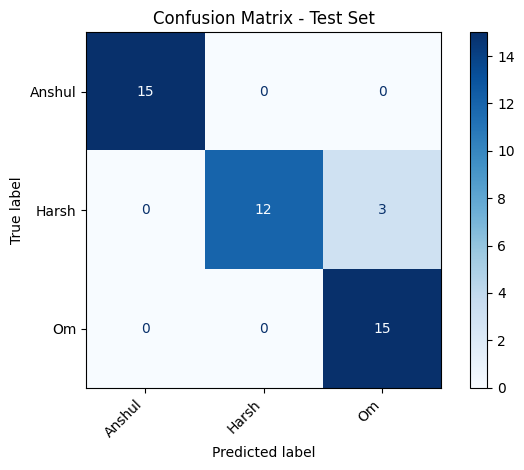

Confusion matrix saved as /content/drive/MyDrive/confusion_matrix.png


In [ ]:
# 10. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
cm_path = '/content/drive/MyDrive/confusion_matrix.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'Confusion matrix saved as {cm_path}')

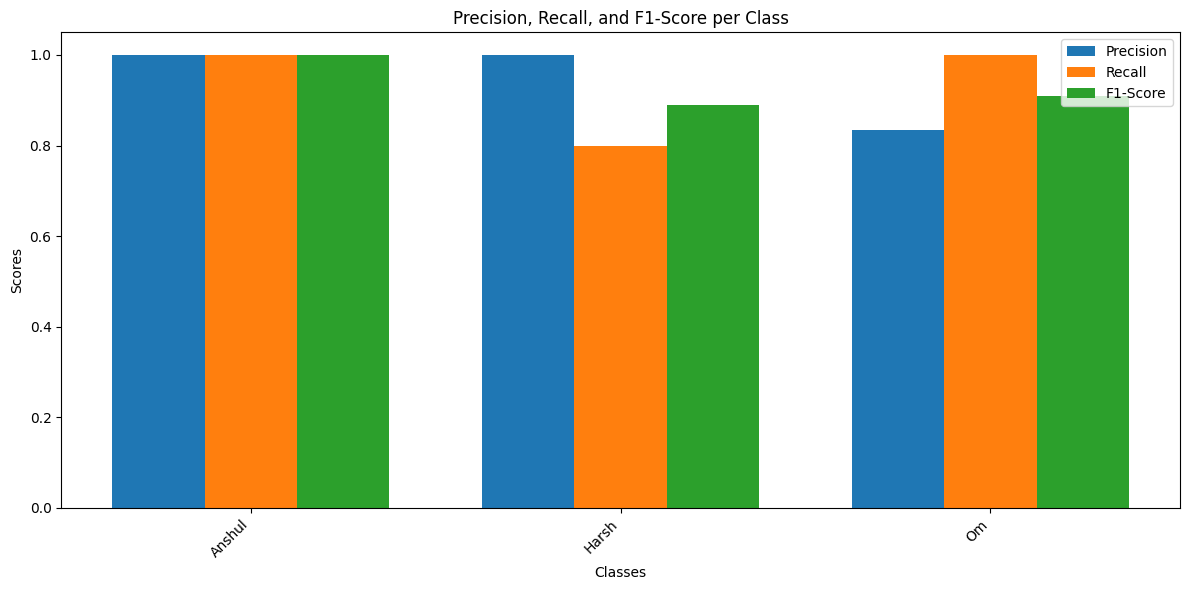

Bar plot saved as /content/drive/MyDrive/class_metrics_barplot.png


In [ ]:
# 11. Bar Plot for Precision, Recall, and F1-Score
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [] for metric in metrics}
for cls in class_names:
    for metric in metrics:
        class_metrics[metric].append(report_dict[cls][metric])

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, class_metrics['precision'], width, label='Precision')
ax.bar(x, class_metrics['recall'], width, label='Recall')
ax.bar(x + width, class_metrics['f1-score'], width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
barplot_path = '/content/drive/MyDrive/class_metrics_barplot.png'
plt.savefig(barplot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'Bar plot saved as {barplot_path}')

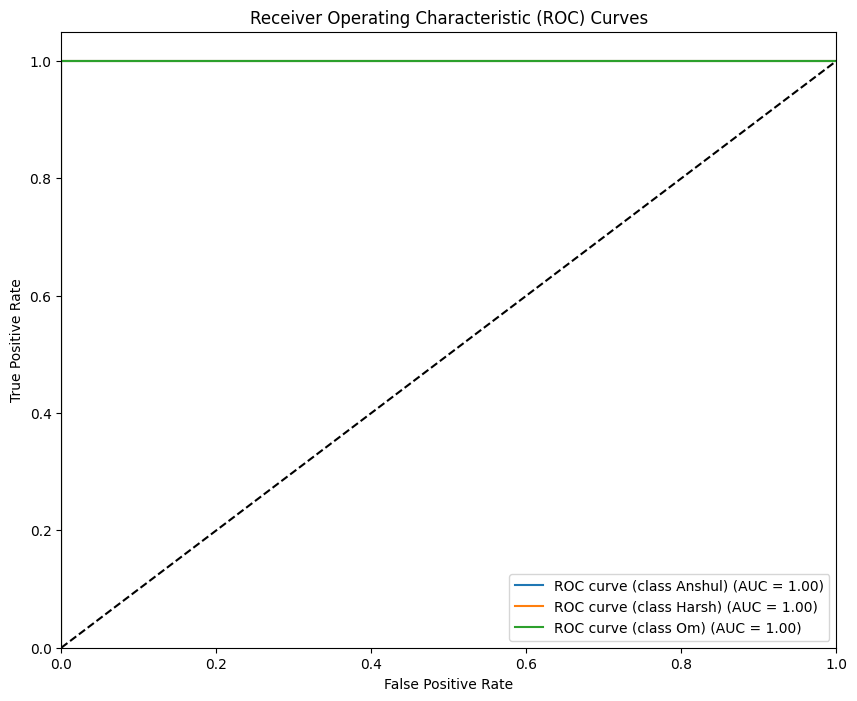

ROC curves saved as /content/drive/MyDrive/roc_curves.png
Metrics summary saved to /content/drive/MyDrive/test_metrics_summary.txt


In [ ]:
# 12. ROC Curve (for multi-class)
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
y_score = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_score.append(torch.softmax(outputs, dim=1).cpu().numpy())
y_score = np.concatenate(y_score)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {class_names[i]}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
roc_path = '/content/drive/MyDrive/roc_curves.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'ROC curves saved as {roc_path}')

# 13. Save All Metrics Summary
summary_path = '/content/drive/MyDrive/test_metrics_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f'Test Accuracy: {test_accuracy:.4f}\n\n')
    f.write('Classification Report:\n')
    f.write(report)
    f.write('\nAUC Scores per Class:\n')
    for i, cls in enumerate(class_names):
        f.write(f'{cls}: {roc_auc[i]:.4f}\n')
print(f'Metrics summary saved to {summary_path}')